In [1]:
%load_ext autoreload
%autoreload 2

## Import libraries

In [2]:
import DemUtils as du
import geoutils as gu

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib

## Download test data

In [4]:
import driveanon

In [5]:
%%capture
driveanon.save('1pBYvIP-K-W5__uJSDjYrL2zVSgGQDK14', filename='data.tar.gz')
! tar -xzvf data.tar.gz -C ./
! rm data.tar.gz

## Load files

In [6]:
dem_fn           = './data/easton_dem.tif'
masked_dem_fn    = './data/easton_dem_glaciers_veg_masked.tif'
reference_dem_fn = './data/reference_dem.tif'

In [7]:
dem           = gu.georaster.Raster(dem_fn)
masked_dem    = gu.georaster.Raster(masked_dem_fn)
reference_dem = gu.georaster.Raster(reference_dem_fn)

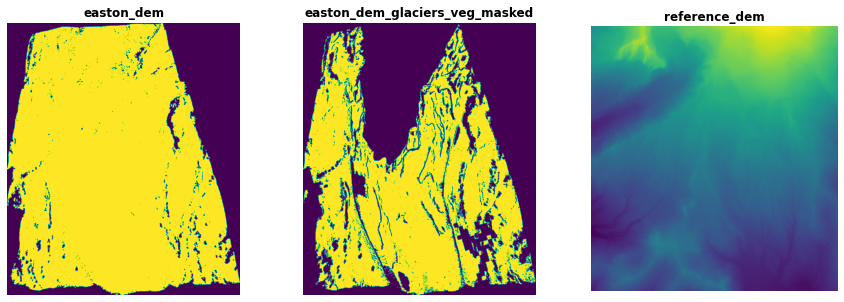

In [8]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
dem.show(ax=ax[0],title=pathlib.Path(dem_fn).stem)
masked_dem.show(ax=ax[1],title=pathlib.Path(masked_dem_fn).stem)
reference_dem.show(ax=ax[2],title=pathlib.Path(reference_dem_fn).stem)
[axi.set_axis_off() for axi in ax.ravel()];

## Reproject and warp to common dims

In [9]:
# rasterio.Resampling.nearest used by default for speed

masked_dem    = masked_dem.reproject(dem, nodata=masked_dem.nodata)
reference_dem = reference_dem.reproject(dem, nodata=reference_dem.nodata)

## Extract numpy.ndarray

In [10]:
# drop dims == 1
# create copies to prevent modifying arrays in place

dem_array           = dem.data.squeeze().copy()
masked_dem_array    = masked_dem.data.squeeze().copy()
reference_dem_array = reference_dem.data.squeeze().copy()

## Validate

In [11]:
dem.crs == masked_dem.crs == reference_dem.crs

True

In [12]:
type(dem_array)

numpy.ndarray

In [13]:
dem_array.shape == masked_dem_array.shape == reference_dem_array.shape

True

## Mask fill values with numpy.nan

In [14]:
def mask_array_with_nan(array,nodata_value):
    """
    Replace dem nodata values with np.nan.
    """
    mask = (array == nodata_value)
    masked_array = np.ma.masked_array(array, mask=mask)
    masked_array = np.ma.filled(masked_array, fill_value=np.nan)
    
    return masked_array

In [15]:
dem_array           = mask_array_with_nan(dem_array,dem.nodata)
masked_dem_array    = mask_array_with_nan(masked_dem_array,masked_dem.nodata)
reference_dem_array = mask_array_with_nan(reference_dem_array,reference_dem.nodata)

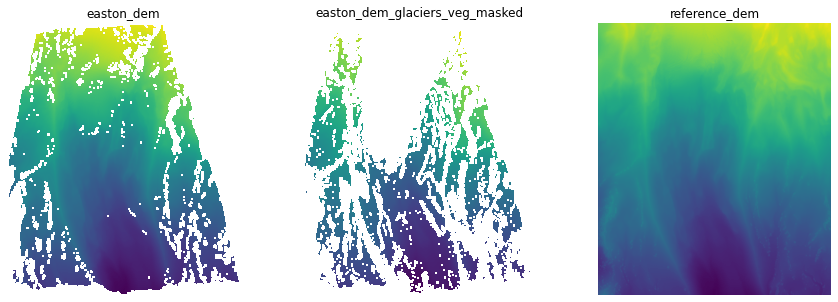

In [16]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(dem_array)
ax[0].set_title(pathlib.Path(dem_fn).stem)
ax[1].imshow(masked_dem_array)
ax[1].set_title(pathlib.Path(masked_dem_fn).stem)
ax[2].imshow(reference_dem_array)
ax[2].set_title(pathlib.Path(reference_dem_fn).stem)
[axi.set_axis_off() for axi in ax.ravel()];

## Initial difference

In [17]:
elevation_difference_array = reference_dem_array - masked_dem_array

In [18]:
nmad_before = du.coreg.calculate_nmad(elevation_difference_array)
print(nmad_before)

0.50457626953125


## Plot

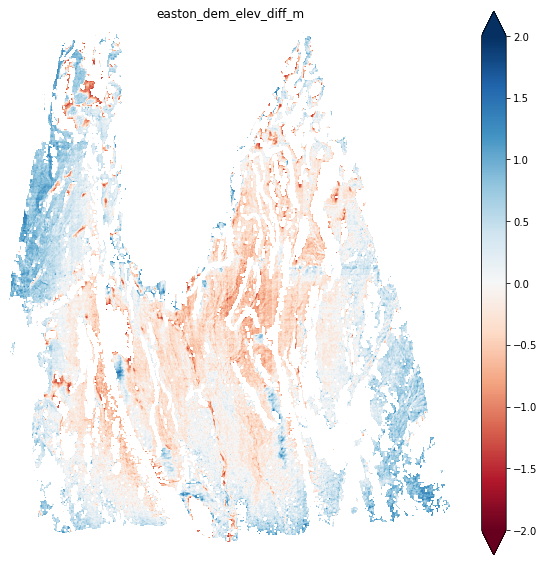

In [19]:
fig,ax = plt.subplots(figsize=(10,10))
im = ax.imshow(elevation_difference_array, cmap='RdBu',clim=(-2, 2))
fig.colorbar(im,extend='both')
ax.set_title(pathlib.Path(dem_fn).stem+'_elev_diff_m')
ax.set_axis_off();

## Fit surface

In [20]:
x_coordinates, y_coordinates = np.meshgrid(
    np.arange(elevation_difference_array.shape[1]),
    np.arange(elevation_difference_array.shape[0])
)

In [21]:
ramp = du.coreg.deramping(elevation_difference_array, x_coordinates, y_coordinates, 2)

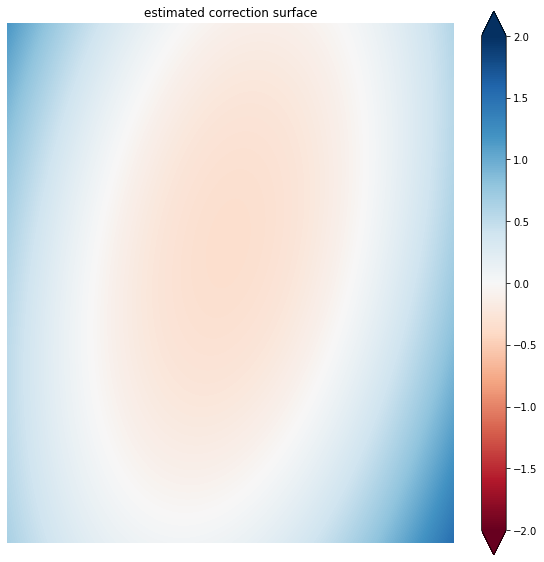

In [22]:
mask_array = np.zeros_like(elevation_difference_array)
mask_array += ramp(x_coordinates, y_coordinates)

fig,ax = plt.subplots(figsize=(10,10))
im = ax.imshow(mask_array, cmap='RdBu',clim=(-2, 2))
fig.colorbar(im,extend='both')
ax.set_title('estimated correction surface')
ax.set_axis_off();

## Correct masked DEM

In [23]:
masked_dem_array_corrected = masked_dem_array.copy()
masked_dem_array_corrected += ramp(x_coordinates, y_coordinates)

In [24]:
elevation_difference_array_corrected = reference_dem_array - masked_dem_array_corrected

In [25]:
nmad_after = du.coreg.calculate_nmad(elevation_difference_array_corrected)
print(nmad_after)

0.3648113715814291


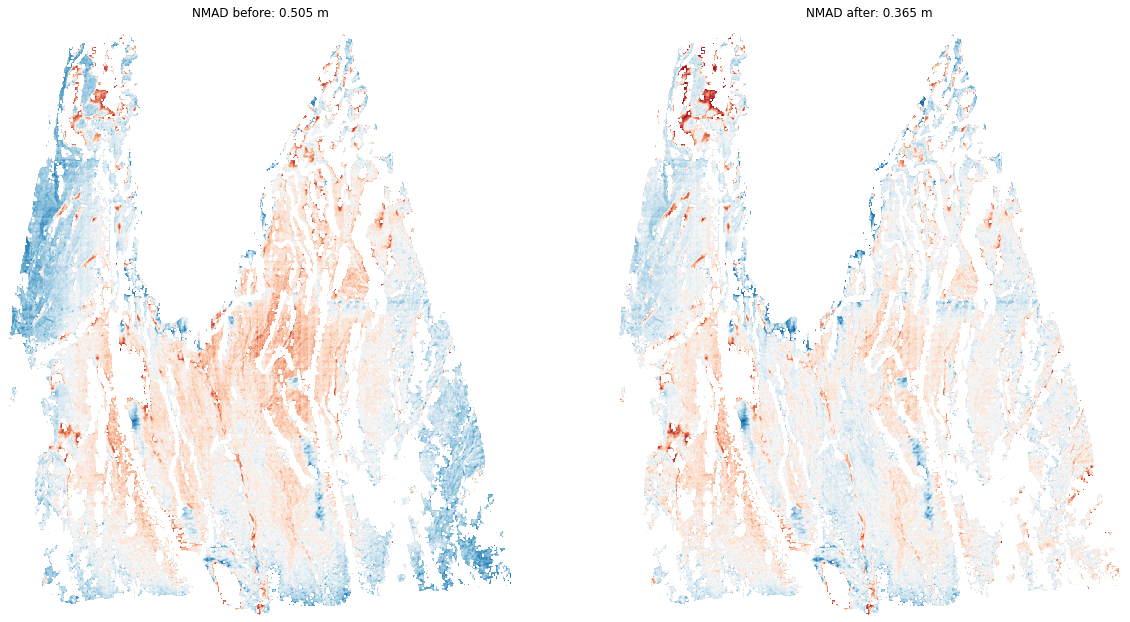

In [26]:
fig,ax = plt.subplots(1,2,figsize=(20,20))
im0 = ax[0].imshow(elevation_difference_array, cmap='RdBu',clim=(-2, 2))
# fig.colorbar(im,extend='both')
ax[0].set_title('NMAD before: '+ f"{nmad_before:.3f} m")
ax[0].set_axis_off();
im1 = ax[1].imshow(elevation_difference_array_corrected, cmap='RdBu',clim=(-2, 2))
# fig.colorbar(im1,extend='both')
ax[1].set_title('NMAD after: '+ f"{nmad_after:.3f} m")
ax[1].set_axis_off();

## Apply correction to unmasked DEM

In [27]:
dem_array += ramp(x_coordinates, y_coordinates)

In [28]:
elevation_difference_dem_array = reference_dem_array - dem_array

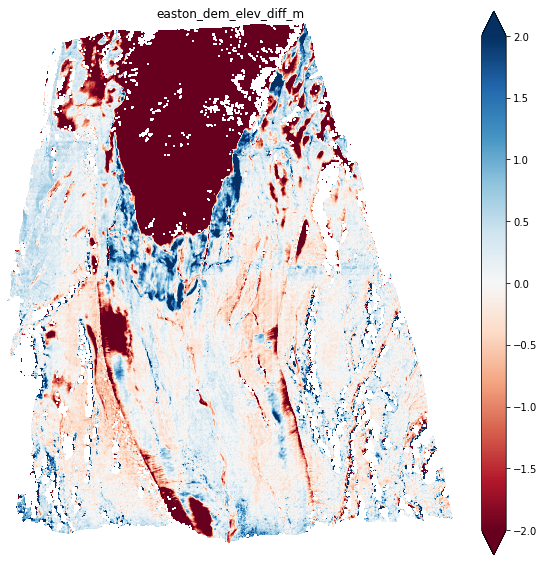

In [29]:
fig,ax = plt.subplots(figsize=(10,10))
im = ax.imshow(elevation_difference_dem_array, cmap='RdBu',clim=(-2, 2))
fig.colorbar(im,extend='both')
ax.set_title(pathlib.Path(dem_fn).stem+'_elev_diff_m')
ax.set_axis_off();

## Write corrected DEM to disk

In [30]:
# should probably change the no data value back and assign more efficient dtype
corrected_dem = gu.georaster.Raster.from_array(
    data=elevation_difference_dem_array,
    transform=dem.transform,
    crs=dem.crs,
    nodata=np.nan
)
out_fn = './data/easton_dem_corrected.tif'
corrected_dem.save(out_fn)